Supporting materials：
1. https://www.kaggle.com/code/scchuy/kaggle-book-sentiment-analysis))
2. https://www.kaggle.com/competitions/tweet-sentiment-extraction/code
3. https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model

# goal for this code：
1. using NLP techniques to transform text into words(stemming only for verbs)

1.1 use them as input for textblob to analysis the sentiment score,bucketing it into 3 groups

1.2 use the results as labels and use randomforest to do the ML tasks

2.  use cleaned words to calculate the frequency(using tf-idf) and creat wordcloud
(also use in creating wordclouds in comments and hashtags respectively)  

techniques involved: 
basic cleaning->Tokenization->Remove stopwords, Punctiuation marks->Normalization ->lowercasing->Spelling correction->singualrize
lemmatization or Stemmting

In [39]:
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from tqdm.notebook import tqdm
import re
from transformers import BertModel, BertTokenizer
import transformers
from tokenizers import BertWordPieceTokenizer
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import os
import nltk
import spacy
import wordnet
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
from string import punctuation
from heapq import nlargest

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus.reader import wordnet

from nltk import word_tokenize
from nltk import tokenize

## explore data

In [14]:
df = pd.read_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/review_data/TweetIDs_Part1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6838 entries, 0 to 6837
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   coordinates                 0 non-null      float64
 1   created_at                  6838 non-null   object 
 2   hashtags                    526 non-null    object 
 3   media                       927 non-null    object 
 4   urls                        1195 non-null   object 
 5   favorite_count              6838 non-null   int64  
 6   id                          6838 non-null   int64  
 7   in_reply_to_screen_name     2716 non-null   object 
 8   in_reply_to_status_id       2620 non-null   float64
 9   in_reply_to_user_id         2716 non-null   float64
 10  lang                        6838 non-null   object 
 11  place                       129 non-null    object 
 12  possibly_sensitive          2006 non-null   object 
 13  quote_id                    658 n

In [15]:
df['text'].sample(20)

5906    @iHM01myself Then you should probably find a m...
4494    Monkey pox is spreading  you wait when we find...
3285               Ian Brown looks like he has monkey pox
2189    @GBNEWS With a face like that, are you sure it...
1020    No-one should be surprised we apparently have ...
2601    $AEMD still unfound on #MonkeyPox $TNXP $GOVX ...
156     You know how I know this country is dying? The...
32      @Jerryhomesweet @JamieSale @TruegritG Monkey p...
2940    The Centers for Disease Control and Prevention...
4913    @ReutersWorld “Monkey Pox” is a racist insult ...
4481    #billgates you can see b gates warning of a sm...
3476                   Monkey pox https://t.co/shPQXowJxx
3737    @Incindery1 Example of scarring due to Small P...
6477      So, when are we getting the Monkey Pox vaccine?
2960    oh wowowow.............. so is the phrase  "un...
5969    Mystery solved!  This is how we ended up with ...
5880    @mattsledge @SFGate Invasive jumping works, mo...
1731    @mario

### extract the txt column and drop duplicated txt

In [18]:
content = pd.DataFrame(df[df.lang=='en']['text'])
print(df.shape)
print(content.shape)
print('null',sum(df[df.lang=='en']['text'].isnull()))
print('duplicates',content.duplicated().sum())

(6838, 35)
(6529, 1)
null 0
duplicates 36


In [22]:
content .drop_duplicates(keep="first",inplace = True)
print('duplicates',content.duplicated().sum())

duplicates 0


In [24]:
# import nltk
# nltk.download()
# 下载完语料库☞    C:\Users\86180\AppData\Roaming\nltk_data

# to do
1. basic cleaning
2. Tokenization
3. Remove stopwords, Punctiuation marks
4. Normalization - lowercasing
5. Spelling correction, singualrize
6. lemmatization or Stemmting
7. Textblob.sentiment - Subjective Score, Polarity Score
8. BOW - TfIDF , CountVectorizer - numerical form
9. ML/DL model inorder to make classification/ regression model

## 1. basic cleaning

In [27]:
def basic_cleaning(text):
    # clear url
    text = re.sub("(http|https|ftp)://[a-zA-Z0-9\\./]+", '', text)
    # clear fuck-bitch swear
    # we can decide whether or not to delete swear(eg. if for Vader，we don't need to do this)
    text = re.sub(r'\*+', 'swear', text)
    # remove tags
    text = re.sub("#(\w+)", " ", text)
    # remove @xxx 
    text = re.sub("(@[A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", text)
    
    # clear not alpha
    text = re.sub(r'[^a-zA-Z|\s]', '', text)
    
    return text

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

# remove repeated characters(over 3 times)
def remove_multiplechars(text):
    """
    for example, so we have “way” instead of “waaaayyyyy”
    """
    text = re.sub(r'(.)\1{1,}', r'\1', text)
    return text

def remove_emoji(text):
    #emoticons
    #symbols & pictographs
    #transport & map symbols
    #flags (iOS)
    emoji_pattern = re.compile("["\
        u"\U0001F600-\U0001F64F|"\
        u"\U0001F300-\U0001F5FF|"\
        u"\U0001F680-\U0001F6FF|"\
        u"\U0001F1E0-\U0001F1FF|"\
        u"\U00002702-\U000027B0|"\
        u"\U000024C2-\U0001F251"\
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [28]:
content['text'][1567] # use this as an example to test our cleaning method

'@TheRebelRise We are already seeing some travel restrictions to certain countries due to covid and advisory for monkey pox.'

In [29]:
def clean(df):
    for col in ['text']:
        df[col] = df[col].astype(str).apply(lambda x:basic_cleaning(x))
        # we can decide whether or not to delete multiplechars(eg. if for Vader，we don't need to do this)
        df[col] = df[col].astype(str).apply(lambda x:remove_multiplechars(x))
        # we can decide whether or not to delete emoji(eg. if for Vader，we don't need to do this)
        df[col] = df[col].astype(str).apply(lambda x:remove_emoji(x)) 
        df[col] = df[col].astype(str).apply(lambda x:remove_html(x))
    return df

content = clean(content)
content['text'][1567]

' We are already seing some travel restrictions to certain countries due to covid and advisory for monkey pox'

## 2. lemmatizer with POS tags

### 2.1 use nltk package "pos_tags" to annotate the  Part-of-Speech

In [30]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus.reader import wordnet

# 实例化
ps=nltk.stem.porter.PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [31]:
# return a 2-dim array
# we can select the tag we want and store it in a list
# example
nltk.pos_tag(['Jogging','Delhi'])

# here N means Noun

[('Jogging', 'VBG'), ('Delhi', 'NNP')]

A POS tag (or part-of-speech tag) is a special label assigned to each token (word) in a text corpus to indicate the part of speech and often also other grammatical categories such as tense, number (plural/singular), case etc.

POS tags are used in corpus searches and in text analysis tools and algorithms.

In [32]:
# function to convert nltk tag to wordnet tag
# we just select 4 main big tags 
def nltk_tag_to_wordnet_tag(nltk_tag):
    
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

## 2.2 lemmatizer with POS tags

In [47]:
# # defining lemmatizer which will take POS tags into consideration before performing lemmatization
from nltk.corpus.reader import wordnet
# note that this package != wordnet itself
def lemmatize_sentence(sentence):   
    
    #tokenize the sentence and find the POS tag for each token
    # return token and its nltk_tag for each token in the sentence
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    
#     print(list(nltk_tagged))
    
    #tuple of (token, wordnet_tag) using the map function
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
        
    lemmatized_sentence = []       
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
#             print('IN CASE OF NONE: ', lemmatized_sentence)
        
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
            
            
#             print('IN CASE OF ELSE : ',lemmatized_sentence)

    
    return " ".join(lemmatized_sentence)

print(lemmatize_sentence(" i have been working on my skills ")) 
# i have be work on my skill

i have be work on my skill


## 3. remove stopwords&punctuation

In [42]:
from nltk.corpus import stopwords
from collections import defaultdict
from string import punctuation

stopwords 是一个列表，包含了英文中那些频繁出现的词，如am, is, are。

defaultdict 是一个带有默认值的字典容器。

puctuation 是一个列表，包含了英文中的标点和符号。


### 3.1 combining  them into a list

In [40]:
stopwords1 = list(stopwords.words('english'))
print('Number of Stopwords:: ', len(stopwords1))
print('Not is present in Stopwords:: ','not' in stopwords1)

Number of Stopwords::  179
Not is present in Stopwords::  True


In [41]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [44]:
stopwords1 = list(stopwords.words('english'))+list(punctuation)
print(len(stopwords1),stopwords1,sep='\n\n')

211

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'tha

### 3.2 Removing Stopwords and punctuatons

In [48]:
from nltk import word_tokenize
from nltk import tokenize

nltk.tokenize 是NLTK提供的分词工具包。

所谓的分词 (tokenize) 实际就是把段落分成句子，把句子分成一个个单词的过程

sent_tokenize() 函数对应的是分段为句

word_tokenize()函数对应的是分句为词。

In [49]:
def clean_text_1(a):
    return  ' '.join([i.lower() for i in tokenize.word_tokenize(a) if i.lower() not in stopwords1])
    
    # Refraning the data having less than 2 tokens
    if len(ls)>2:
        val= ' '.join(ls)
        return val
    else :
        return None

In [50]:
def clean_text_2(a):
    return  [i.lower() for i in tokenize.word_tokenize(a) if i.lower() not in stopwords1]

In [52]:
content['clean_txt'] = content['text'].apply(clean_text_2)
# performing tokenization -> stopword removal -> normalization -> allowing sentences having more than 3 tokens
content.sample(10)

,text,clean_txt
5402,NOT THEM TALKING ABOUT MONKEY POX ON THE NEWS ...,"[talking, monkey, pox, news, im, serious, wil,..."
3943,And they rol out the next health emergency ak...,"[rol, next, health, emergency, aka, monkey, po..."
3739,ctmarkets Monkey pox is bulish no They wil pr...,"[ctmarkets, monkey, pox, bulish, wil, print, m..."
6164,Monkey pox,"[monkey, pox]"
6071,Dont forget the monkey pox,"[dont, forget, monkey, pox]"
3966,Fabricant The Guys at Rainbow may have Monkey...,"[fabricant, guys, rainbow, may, monkey, pox, z..."
62,Are you talking about monkey pox or Covid,"[talking, monkey, pox, covid]"
6014,I got moneypox the way my funds be spreading,"[got, moneypox, way, funds, spreading]"
4258,More monkey busines,"[monkey, busines]"
263,Sory smalpox vacine efective against monkey pox,"[sory, smalpox, vacine, efective, monkey, pox]"


## 4. Lemmatization 

In [53]:
# Lemmatization by only considering Verb for the clean data
def clean_text_lemma(a):
    val= ' '.join([lemmatizer.lemmatize(i.lower(),pos = 'v') for i in tokenize.word_tokenize(a) if i.lower() not in stopwords1])
    return val

# Stemming on clean data
def clean_text_stem(a):  
    
    val= ' '.join([ps.stem(i.lower()) for i in tokenize.word_tokenize(a) if i.lower() not in stopwords1])
    return val

In [54]:
# Lemmatization by only considering Verb for the clean data
content['clean_lemma'] = content['clean_txt'].apply (lambda x:' '.join(x)).apply(clean_text_lemma)

# Lemmatization by considering respective POS tags
content['clean_lemma_pos'] = content['clean_txt'].apply (lambda x:' '.join(x)).apply(lemmatize_sentence)

# Stemming on clean data
content['clean_stem_txt'] = content['clean_txt'].apply (lambda x:' '.join(x)).apply(clean_text_stem)

In [55]:
content.head(20)

,text,clean_txt,clean_lemma,clean_lemma_pos,clean_stem_txt
0,Watch the progresive monkeys run out screaming...,"[watch, progresive, monkeys, run, screaming, p...",watch progresive monkey run scream pfizerpoxga...,watch progresive monkey run scream pfizerpoxga...,watch progres monkey run scream pfizerpoxgates...
1,When you have Bil Gates shorting Tesla for ha...,"[bil, gates, shorting, tesla, half, bilion, me...",bil gate short tesla half bilion media monkey ...,bil gate short tesla half bilion medium monkey...,bil gate short tesla half bilion media monkey ...
2,Monkey pox as reported by Reuters \n\nGay bise...,"[monkey, pox, reported, reuters, gay, bisexual...",monkey pox report reuters gay bisexual men sex...,monkey pox report reuters gay bisexual men sex...,monkey pox report reuter gay bisexu men sex me...
3,Hey Pete\nPeople are crazy Busy\nWe cant expe...,"[hey, pete, people, crazy, busy, cant, expect,...",hey pete people crazy busy cant expect worying...,hey pete people crazy busy cant expect worying...,hey pete peopl crazi busi cant expect wori cov...
4,tx FDA Wel you know the new thing is monkey p...,"[tx, fda, wel, know, new, thing, monkey, pox, ...",tx fda wel know new thing monkey pox right vac...,tx fda wel know new thing monkey pox right vac...,tx fda wel know new thing monkey pox right vac...
5,Disease Detection Laboratories on the front li...,"[disease, detection, laboratories, front, line...",disease detection laboratories front line blog...,disease detection laboratories front line blog...,diseas detect laboratori front line blog cdc m...
7,This monkey pox is starting to give me early C...,"[monkey, pox, starting, give, early, covid, vi...",monkey pox start give early covid vibes,monkey pox start give early covid vibe,monkey pox start give earli covid vibe
8,So reading on how this monkey pox virus spread...,"[reading, monkey, pox, virus, spreads, wouldnt...",read monkey pox virus spread wouldnt surprise ...,read monkey pox virus spread wouldnt surprise ...,read monkey pox viru spread wouldnt surpris se...
9,Monkey pox,"[monkey, pox]",monkey pox,monkey pox,monkey pox
10,Monkey Pox by,"[monkey, pox]",monkey pox,monkey pox,monkey pox


In [27]:
#content.to_csv("C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/clean_without_num.csv", index=False)

#### extract feature below(useless for final goal)

In [57]:
##  Vectorize
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit_transform(content['clean_stem_txt'])
print(vect.get_feature_names()[:20])

['aah', 'aand', 'aap', 'aardvark', 'ab', 'abandon', 'abc', 'abeg', 'abil', 'abl', 'ablaz', 'abnorm', 'abort', 'abound', 'aboutlos', 'abrevi', 'absc', 'absenc', 'absolut', 'absurd']


## 5. Calculating Sentiment Score&bucketing into 3 groups

for textblob:
Polarity Score is float which lies in the range of [-1,1] 

Subjectivity is also a float which lies in the range of [0,1]

0--- personal
1---factual

In [58]:
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer
# Using Textblob.Sentiment to calculate the sentiment score w.r.t to every cusotmer review
content['sentiment'] = content['clean_lemma_pos'].apply(lambda reveiw: TextBlob(reveiw).sentiment)

In [59]:
content['sent_text'] = content['text'].apply(lambda reveiw: TextBlob(reveiw).sentiment)
content['Polarity'] = content['sentiment'].apply(lambda x: round(x[0],2)) 
content['Subjectivity'] = content['sentiment'].apply(lambda x: round(x[1],2)) 
# use threshold 0.05 as example
content['Polarity_buckets'] = content['Polarity'].apply(lambda x: 'negative' if x<=-0.05 else 'nuetral' if (x<=0.05) else 'positive')
#print(df.shape[0])
content['Polarity_buckets'].value_counts(normalize = True)*100

6838


negative    58.308948
nuetral     21.346065
positive    20.344987
Name: Polarity_buckets, dtype: float64

In [60]:
# compare with the whole sentence 
content['txt_Polarity'] = content['sent_text'].apply(lambda x: round(x[0],2)) 
content['txt_Subjectivity'] = content['sent_text'].apply(lambda x: round(x[1],2)) 
# use threshold 0.05 as example
content['Po_buckets'] = content['txt_Polarity'].apply(lambda x: 'negative' if x<=-0.05 else 'nuetral' if (x<=0.05) else 'positive')
# print(df.shape[0])
content['Po_buckets'].value_counts(normalize = True)*100

6838


negative    55.629139
positive    22.762976
nuetral     21.607885
Name: Po_buckets, dtype: float64

In [61]:
del content['sentiment']
del content['sent_text']

In [64]:
print('MonkeyPox',TextBlob('MonkeyPox').sentiment)
print('monkey pox',TextBlob('monkey pox').sentiment)

print(content['text'].iloc[0])
print('Polarity ',content['Polarity'].iloc[0])
print('Subjectivity ',content['Subjectivity'].iloc[0])
print('txt_Polarity ',content['txt_Polarity'].iloc[0])
print('txt_Subjectivity ',content['txt_Subjectivity'].iloc[0])
print('Po_buckets ',content['Po_buckets'].iloc[0])
print('Polarity_buckets ',content['Polarity_buckets'].iloc[0])

pd.set_option('display.width',10000) # display full length

MonkeyPox Sentiment(polarity=0.0, subjectivity=0.0)
monkey pox Sentiment(polarity=-0.05, subjectivity=0.0)
Watch the progresive monkeys run out screaming for their PfizerpoxGatespox poison and redouble their myocarditis In other news after they are dead fewer people grabing for fod and fuel 


Polarity  -0.15
Subjectivity  0.17
txt_Polarity  -0.16
txt_Subjectivity  0.39
Po_buckets  negative
Polarity_buckets  negative


In [66]:
content['Score']=content['Polarity_buckets'].apply(lambda x:1 if x=='positive' else -1 if x=='negative' else 0)
content['Score']

0      -1
1      -1
2       1
3      -1
4       1
       ..
6833   -1
6834    0
6835   -1
6836   -1
6837    1
Name: Score, Length: 6493, dtype: int64

## 6. ML-training

In [67]:
# Creating Training and Testng Data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(content['clean_lemma_pos'],
                                                    content['Score'],
                                                    test_size = 0.2,
                                                    random_state = 37)

In [68]:
print('length of training data',len(x_train))
print('length of y_training data',len(y_train))
print('length of X_training data',len(x_test))

length of training data 5194
length of y_training data 5194
length of X_training data 1299


### 6.1 using tf-idf to calculate the frequency of words
1) Count vectorizer - give only count --> tfidf transformer ---> tf *idf

2) Tf-idfVectorizer - tf , idf

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(min_df = 0.01)
tf_idf.fit_transform(x_train)
tf_idf_x_train = tf_idf.fit_transform(x_train).toarray() 
# to have sparse matrix converted in form of array
tf_idf_x_test = tf_idf.transform(x_test).toarray()

display( tf_idf_x_train, tf_idf_x_train.shape)

array([[0.        , 0.52481909, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.64799231, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

(5194, 146)

In [70]:
print(max(tf_idf_x_train[0]))
print(np.argmax(tf_idf_x_train[0]))

0.5248190901469434
1


In [71]:
# lenght of tfidf vocalbulary/ features
len(tf_idf.vocabulary_)

146

In [72]:
# tfidf vocalbulary/ features
tf_idf.vocabulary_

{'wil': 136,
 'se': 99,
 'us': 123,
 'lockdown': 62,
 'monkey': 76,
 'pox': 91,
 'al': 1,
 'covid': 24,
 'get': 42,
 'moneypox': 75,
 'know': 58,
 'one': 85,
 'think': 117,
 'sure': 110,
 'something': 105,
 'cant': 16,
 'pandemic': 87,
 'might': 74,
 'wel': 134,
 'god': 45,
 'way': 132,
 'plan': 89,
 'come': 20,
 'smal': 103,
 'back': 8,
 'stil': 108,
 'whats': 135,
 'next': 82,
 'mask': 69,
 'go': 44,
 'amp': 4,
 'people': 88,
 'dont': 30,
 'give': 43,
 'bad': 9,
 'maybe': 71,
 'shit': 101,
 'isnt': 54,
 'real': 94,
 'even': 33,
 'tel': 113,
 'vacine': 125,
 'case': 17,
 'let': 60,
 'wear': 133,
 'long': 66,
 'day': 25,
 'smalpox': 104,
 'fear': 36,
 'yet': 145,
 'kep': 57,
 'disease': 28,
 'doesnt': 29,
 'fuck': 39,
 'please': 90,
 'im': 53,
 'make': 67,
 'put': 92,
 'today': 119,
 'year': 144,
 'believe': 10,
 'wory': 141,
 'wtf': 143,
 'like': 61,
 'stop': 109,
 'first': 38,
 'lok': 63,
 'loks': 64,
 'thats': 115,
 'bil': 14,
 'gate': 40,
 'country': 23,
 'may': 70,
 'outbreak': 86

#### 6.2 use randomforest to do the classification

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# compare with RandomForestClassifier 
rf_clf = RandomForestClassifier()
rf_clf.fit(tf_idf_x_train, y_train)
rf_pred = rf_clf.predict(tf_idf_x_test)

print('Random Forest Accuracy Score:  ',np.round(accuracy_score(y_test,rf_pred)*100,0))

Random Forest Accuracy Score:   75.0


## 7. visualization: creating wordcloud 

In [74]:
# Importing libraries for creating wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image # The pillow library is a package that enables image reading
import urllib # This is used for opening URLs
import requests # Allows to Send requests

In [75]:
# Creating Data with their respective Part of Speechs
sentence = ' '.join(content.clean_lemma_pos.values)
blob = TextBlob(sentence)
tg = blob.tags
# print(sentence,tg,sep='\n\n')

<Figure size 1200x800 with 0 Axes>

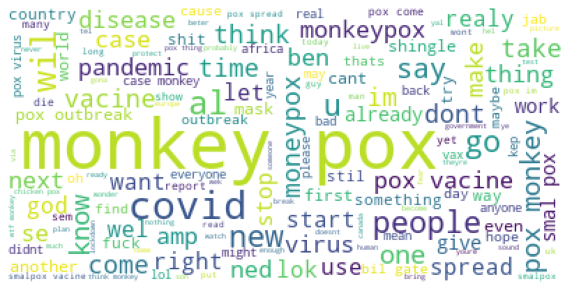

In [76]:
#Simple Word CLoud
p=plt.figure(dpi=200) #调整像素
#mask = plt.imread('/Users/86180/Desktop/泰迪杯--赛前培训/微信图片_20220409113338.jpg')
wordcloud = WordCloud(max_font_size=50, 
                      max_words=150, 
                      background_color="white",
#                       color_func=lambda *args, **kwargs:(150,100,100),
                      stopwords= STOPWORDS).generate(sentence)


plt.figure(figsize=(10,8))

plt.imshow(wordcloud) # Command to show the image
plt.axis("off") # to Turnoff the axis
#plt.savefig('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/wordcloud')#保存图片
plt.show()
